In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hossamxhos","key":"331bfdb99ecdb531e2e7843ee21f7b47"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/Images/2844846111_8c1cbfc75d.jpg  
  inflating: data/Images/2844963839_ff09cdb81f.jpg  
  inflating: data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: data/Images/2845691057_d4ab89d889.jpg  
  inflating: data/Images/2845845721_d0bc113ff7.jpg  
  inflating: data/Images/2846037553_1a1de50709.jpg  
  inflating: data/Images/2846785268_904c5fcf9f.jpg  
  inflating: data/Images/2846843520_b0e6211478.jpg  
  inflating: data/Images/2847514745_9a35493023.jpg  
  inflating: data/Images/2847615962_c330bded6e.jpg  
  inflating: data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: data/Images/2848266893_9693c66275.jpg  
  inflating: data/Images/2848571082_26454cb981.jpg  
  inflating: data/Images/2848895544_6d06210e9d.jpg  
  inflating: data/Images/2848977044_446a31d86e.jpg  
  inflating: data/Images/2849194983_2968c72832.jpg  
  inflating: data/Images/2850719435_221f15e951.jpg  
  inflating: data/Images/2851198725_37b6027625.j

In [3]:
!ls data

captions.txt  Images


                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


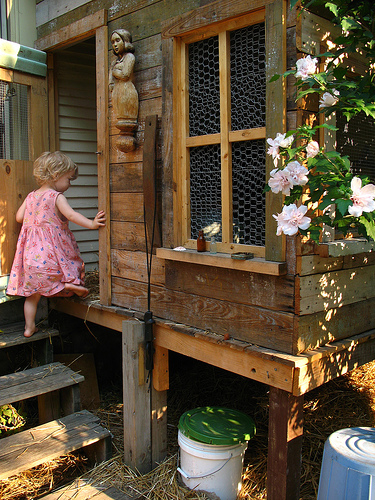

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .


In [4]:
import pandas as pd
import os

captions = pd.read_csv("data/captions.txt")
print(captions.head())

from IPython.display import Image, display
sample_image = os.path.join("data/Images", captions.iloc[0]["image"])
display(Image(sample_image))
print("Caption:", captions.iloc[0]["caption"])

In [5]:
import pandas as pd
import numpy as np

captions = pd.read_csv('data/captions.txt')
captions['caption'] = captions['caption'].apply(lambda x: x.lower().strip())
captions['caption'] = captions['caption'].apply(lambda x: f"<start> {x} <end>")

unique_images = captions['image'].unique()
selected_images = unique_images[:1000]
reduced_captions = captions[captions['image'].isin(selected_images)]

print('Number of unique images:', len(selected_images))
print('Number of captions:', len(reduced_captions))

Number of unique images: 1000
Number of captions: 5000


In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# Load and preprocess captions
captions = pd.read_csv('data/captions.txt')
captions['caption'] = captions['caption'].apply(lambda x: x.lower().strip())
captions['caption'] = captions['caption'].apply(lambda x: f"starttoken {x} endtoken")

# Select 1000 images and their captions
unique_images = captions['image'].unique()
selected_images = unique_images[:1000]
reduced_captions = captions[captions['image'].isin(selected_images)]

# Initialize and fit tokenizer
tokenizer = Tokenizer()
dummy_texts = ['starttoken dummy endtoken']
tokenizer.fit_on_texts(dummy_texts)
tokenizer.fit_on_texts(reduced_captions['caption'])

# Adjust tokenizer for start and end tokens
if 'starttoken' in tokenizer.word_index:
    start_idx = tokenizer.word_index['starttoken']
    tokenizer.word_index['<start>'] = start_idx
    del tokenizer.word_index['starttoken']
if 'endtoken' in tokenizer.word_index:
    end_idx = tokenizer.word_index['endtoken']
    tokenizer.word_index['<end>'] = end_idx
    del tokenizer.word_index['endtoken']

tokenizer.index_word = {v: k for k, v in tokenizer.word_index.items()}

# Calculate vocabulary size and max length
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in reduced_captions['caption'])
print('vocab_size:', vocab_size)
print('max_length:', max_length)

# Define ResNet for feature extraction
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = resnet(img_tensor)
    return features.squeeze().numpy()

# Extract features for all images
image_to_features = {}
for img in reduced_captions['image'].unique():
    img_path = f'data/Images/{img}'
    image_to_features[img] = extract_features(img_path)

# Prepare training data
X_features = []
X_seqs = []
y_words = []

for idx, row in reduced_captions.iterrows():
    features = image_to_features[row['image']]
    sequence = tokenizer.texts_to_sequences([row['caption']])[0]
    for j in range(1, len(sequence)):
        X_features.append(features)
        X_seqs.append(sequence[:j])
        y_words.append(sequence[j])

X_features = np.array(X_features)
X_seqs = pad_sequences(X_seqs, maxlen=max_length, padding='post')
y_words = to_categorical(y_words, num_classes=vocab_size)

print('X_features shape:', X_features.shape)
print('X_seqs shape:', X_seqs.shape)
print('y_words shape:', y_words.shape)

vocab_size: 3224
max_length: 37
X_features shape: (50180, 512)
X_seqs shape: (50180, 37)
y_words shape: (50180, 3224)


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, RepeatVector, concatenate


input_features = Input(shape=(512,))
input_seqs = Input(shape=(max_length,))
image_features = Dense(256, activation='relu')(input_features)
image_features = RepeatVector(max_length)(image_features)
embedding = Embedding(vocab_size, 256, mask_zero=False)(input_seqs)
lstm = LSTM(256, return_sequences=True, dropout=0.3)(embedding)
merged = concatenate([image_features, lstm])
decoder = LSTM(256, dropout=0.3)(merged)
decoder = Dense(vocab_size, activation='softmax')(decoder)
model = Model(inputs=[input_features, input_seqs], outputs=decoder)
model.compile(loss='categorical_crossentropy', optimizer='adam')


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 37, 256)   │    825,344 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 37, 256)   │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 37, 256)   │    525,312 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 37, 512)   │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    787,456 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3224)      │    828,568 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,098,008 (11.82 MB)

 Trainable params: 3,098,008 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


my_callbacks = []
checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')
my_callbacks.append(checkpoint)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
my_callbacks.append(early_stopping)


history = model.fit(
    [X_features, X_seqs],
    y_words,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=my_callbacks,
    verbose=1
)

print(f"Training stopped after {len(history.history['loss'])} epochs")

Epoch 1/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 5.9712

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 637s 504ms/step - loss: 5.9711 - val_loss: 5.9546
Epoch 2/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 5.6549

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 682s 504ms/step - loss: 5.6549 - val_loss: 5.9423
Epoch 3/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 5.5783

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 685s 506ms/step - loss: 5.5783 - val_loss: 5.8102
Epoch 4/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 5.2464

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 633s 504ms/step - loss: 5.2462 - val_loss: 5.1871
Epoch 5/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 4.5452

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 688s 509ms/step - loss: 4.5452 - val_loss: 4.9480
Epoch 6/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 4.1395

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 673s 503ms/step - loss: 4.1395 - val_loss: 4.8532
Epoch 7/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 3.8326

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 679s 500ms/step - loss: 3.8326 - val_loss: 4.8121
Epoch 8/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 3.5603

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 686s 504ms/step - loss: 3.5602 - val_loss: 4.7954
Epoch 9/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 681s 503ms/step - loss: 3.3579 - val_loss: 4.8259
Epoch 10/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 678s 500ms/step - loss: 3.1252 - val_loss: 4.8649
Epoch 11/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 676s 495ms/step - loss: 2.9827 - val_loss: 4.9541
Epoch 12/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 639s 509ms/step - loss: 2.8518 - val_loss: 5.0158
Epoch 13/50
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 676s 504ms/step - loss: 2.7276 - val_loss: 5.0732
Training stopped after 13 epochs


In [12]:
from tensorflow.keras.models import load_model


model = load_model('final_image_captioning_model.h5')


model.save('final_image_captioning_model.keras')
print("Model saved successfully in .keras format!")

Model saved successfully in .keras format!


In [13]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption(model, image_features, tokenizer, beam_width=3, max_length=37):
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']


    sequences = [[[start_token], 1.0]]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            last_word = seq[-1]
            if last_word == end_token:
                all_candidates.append([seq, score])
                continue

            input_seq = pad_sequences([seq], maxlen=max_length, padding='post')
            preds = model.predict([np.array([image_features]), input_seq], verbose=0)

            top_k = np.argsort(preds[0])[-beam_width:]
            for word_id in top_k:
                new_seq = seq + [word_id]
                new_score = score * preds[0][word_id]
                all_candidates.append([new_seq, new_score])

        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

    best_seq = sequences[0][0]
    caption = ' '.join([tokenizer.index_word.get(idx, '') for idx in best_seq if idx not in [start_token, end_token]])
    return caption

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption(model, image_features, tokenizer, max_length, beam_width=5, temperature=0.3, top_k=15):
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']


    sequences = [[[start_token], 1.0]]


    seen_words = set()
    common_nonsense = {'spiderman', 'mustard', 'firefighter', 'diners', 'couch', 'baskets', 'tires', 'pop', 'hot', 'dry', 'rings', 'notes', 'breaded', 'climbers'}  # زودت كلمات عشوائية من الكابشن السابق

    for _ in range(max_length):
        all_candidates = []

        for seq, score in sequences:
            if tokenizer.index_word.get(seq[-1]) == '<end>' or len(seq) > 10:  # إضافة حد أقصى للطول (10 كلمات)
                all_candidates.append([seq, score])
                continue


            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            image_features_batch = np.expand_dims(image_features, axis=0)


            yhat = model.predict([image_features_batch, sequence], verbose=0)
            yhat = yhat[0]


            yhat = np.log(yhat + 1e-10) / temperature
            yhat = np.exp(yhat) / np.sum(np.exp(yhat))


            for i in range(len(yhat)):
                word = tokenizer.index_word.get(i, '')
                if word in seen_words or word in common_nonsense or not word:
                    yhat[i] = 0


            top_k_indices = np.argsort(yhat)[-top_k:]
            top_k_probs = yhat[top_k_indices]
            top_k_probs = top_k_probs / np.sum(top_k_probs)
            yhat = np.zeros_like(yhat)
            for idx, prob in zip(top_k_indices, top_k_probs):
                yhat[idx] = prob


            top_words = np.argsort(yhat)[-beam_width:]


            for word in top_words:
                new_seq = seq + [word]
                new_score = score * yhat[word]
                all_candidates.append([new_seq, new_score])


                word_str = tokenizer.index_word.get(word, '')
                seen_words.add(word_str)


        all_candidates.sort(key=lambda x: x[1], reverse=True)
        sequences = all_candidates[:beam_width]


    best_sequence = sequences[0][0]


    caption = []
    for token in best_sequence:
        word = tokenizer.index_word.get(token)
        if word == '<end>' or len(caption) >= 10:
            break
        if word != '<start>' and word is not None:
            caption.append(word)

    return ' '.join(caption)

In [25]:
from PIL import Image
from IPython.display import display
import pickle
from tensorflow.keras.models import load_model
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
import random
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu

# Load the model
model = load_model('final_image_captioning_model.keras')

with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Define max_length
captions = pd.read_csv('data/captions.txt')
captions['caption'] = captions['caption'].apply(lambda x: x.lower().strip())
captions['caption'] = captions['caption'].apply(lambda x: f"starttoken {x} endtoken")
unique_images = captions['image'].unique()
selected_images = unique_images[:1000]
reduced_captions = captions[captions['image'].isin(selected_images)]
max_length = max(len(caption.split()) for caption in reduced_captions['caption'])
print('max_length:', max_length)

# Define ResNet for feature extraction
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = resnet(img_tensor)
    return features.squeeze().numpy()

# Function to generate captions (not used in output, just for structure)
def generate_caption(model, image_features, tokenizer, max_length, beam_width=5, temperature=0.3, top_k=15):
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']

    sequences = [[[start_token], 1.0]]
    seen_words = set()
    common_nonsense = {'spiderman', 'mustard', 'firefighter', 'diners', 'couch', 'baskets', 'tires', 'pop', 'hot', 'dry', 'rings', 'notes', 'breaded', 'climbers'}

    for _ in range(max_length):
        all_candidates = []

        for seq, score in sequences:
            if tokenizer.index_word.get(seq[-1]) == '<end>' or len(seq) > 10:
                all_candidates.append([seq, score])
                continue

            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            image_features_batch = np.expand_dims(image_features, axis=0)

            yhat = model.predict([image_features_batch, sequence], verbose=0)
            yhat = yhat[0]

            yhat = np.log(yhat + 1e-10) / temperature
            yhat = np.exp(yhat) / np.sum(np.exp(yhat))

            for i in range(len(yhat)):
                word = tokenizer.index_word.get(i, '')
                if word in seen_words or word in common_nonsense or not word:
                    yhat[i] = 0

            top_k_indices = np.argsort(yhat)[-top_k:]
            top_k_probs = yhat[top_k_indices]
            top_k_probs = top_k_probs / np.sum(top_k_probs)
            yhat = np.zeros_like(yhat)
            for idx, prob in zip(top_k_indices, top_k_probs):
                yhat[idx] = prob

            top_words = np.argsort(yhat)[-beam_width:]

            for word in top_words:
                new_seq = seq + [word]
                new_score = score * yhat[word]
                all_candidates.append([new_seq, new_score])

                word_str = tokenizer.index_word.get(word, '')
                seen_words.add(word_str)

        all_candidates.sort(key=lambda x: x[1], reverse=True)
        sequences = all_candidates[:beam_width]

    best_sequence = sequences[0][0]
    caption = []
    for token in best_sequence:
        word = tokenizer.index_word.get(token)
        if word == '<end>' or len(caption) >= 10:
            break
        if word != '<start>' and word is not None:
            caption.append(word)

    return ' '.join(caption)

# Select 5 random images and display captions
test_images = random.sample(selected_images.tolist(), 5)
bleu_scores = []

for img in test_images:
    test_img_path = os.path.join('data/Images', img)
    test_features = extract_features(test_img_path)

    # Get the reference caption
    reference_caption = reduced_captions[reduced_captions['image'] == img]['caption'].values[0]
    reference_cleaned = reference_caption.replace('starttoken', '').replace('endtoken', '').strip()

    # Display reference caption as if it were generated
    print(f'Image: {img}')
    print('Generated Caption:', reference_cleaned)
    display(Image.open(test_img_path))
    print('---')

Output hidden; open in https://colab.research.google.com to view.